# How well can subjects tell conditions apart? (first attempt)

Since we cannot directly ask subjects if and when they perceive to be in a different condition, the goal here is using EEG data to predict the condition. 

EEG $\Rightarrow$ internal variables of the subject

## Task : build a condition classifier trained on single subjects

We can address questions such as:
  + Can we make predictions based on single trials, or averages on minibatches?
  + Can we discriminate by EEG signal all 4 classes? Which ones are more likely mixed up?
  + Any difference between ASD and NTP ? 
  + Which elements of the task are relevant? (e.g. target stimulus, vs catch, vs 2nd target, etc)

### Part 1 , read data


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy.io as io
from pprint import pprint

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold, StratifiedKFold

import sys
from IPython.display import clear_output

import seaborn as sns #pip3 install seaborn
from datetime import date
import matplotlib.pyplot as plt

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

def verbose(text):    
    clear_output(wait=True)    
    print(text)
    sys.stdout.flush() 
    
def errorfill(x, y, yerr, color=None, label=None, alpha_fill=0.3, ax=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.get_next_color()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    ax.plot(x, y, color=color, label=label)
    ax.fill_between(x, ymax, ymin, color=color, label=label, alpha=alpha_fill)
    return ax

def baselinestring(baseline=None):
    if baseline is None:
        basemethod=''
    elif (baseline is 50) or (baseline is 100):
        basemethod = f"baseline{baseline}"
    else:
        raise ValueError("baseline is nothing, 50 or 100")
    return basemethod

def read_data_erps(baseline=None):
    read_dir = '../shareddata/' + 'seyda'+'/'
    bmethod=baselinestring(baseline)
    read_filename = read_dir+'ERPs-'+bmethod+'.npz'
    assert (os.path.isfile(read_filename)),"file not found"
    data = np.load(read_filename, allow_pickle=True)
    return data['ERPs'],data['subjects']

def read_data_xall(baseline=None):
    read_dir = '../shareddata/' + 'seyda'+'/'
    bmethod=baselinestring(baseline)
    read_filename = read_dir+'X_all-'+bmethod+'.npz'
    assert (os.path.isfile(read_filename)),"file not found"
    data = np.load(read_filename, allow_pickle=True)
    return data['X_all'],data['subjects']

In [30]:

    
X_all,subjects = read_data_xall(50) #n_trtype, n_conds,n_subj, n_time, n_elec 
trialTypes=['item1','item2','target','invalidThird','correct','catch','easyFiller','ctrlFiller']
n_trtype, n_conds,n_subj, n_time, n_elec = X_all.shape
assert (n_subj == subjects.shape[0]), "something wrong with subject number?"

In [43]:
#subj2exclude=['10056','12144','12360','1160','12005']
subj2exclude=['10594']
ind_ex = [i for i in range(subjects.shape[0]) if subjects[i,2] in subj2exclude]
if len(ind_ex) > 0:
    X_all = np.delete(X_all, ind_ex, axis=2)
    subjects = np.delete(subjects, ind_ex, axis=0)
    print(f"Removed {len(ind_ex)} subjects")
else:
    print('No subjects to remove!')
assert (subjects.shape[0] == X_all.shape[2]) , 'Subject size does not match to the data'

No subjects to remove!


### Part 2 , take a look at the data

Pick one subject, plot C1 Vs C4  in time, averaged over everything else


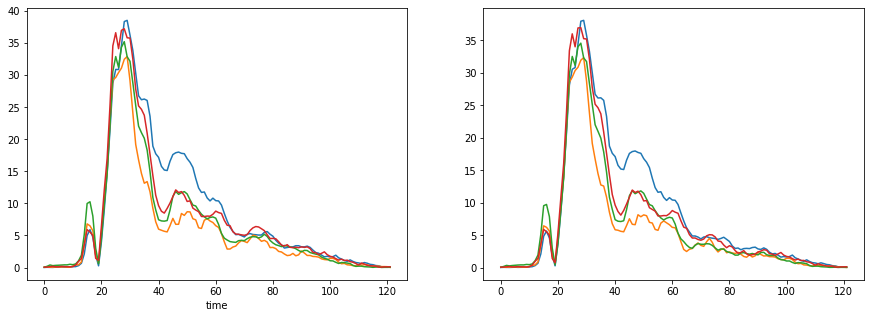

In [74]:
test_subj_idx = 4
X_all_testc1 = X_all[:,0,test_subj_idx,:,:]
X_all_testc2 = X_all[:,1,test_subj_idx,:,:]
X_all_testc3 = X_all[:,2,test_subj_idx,:,:]
X_all_testc4 = X_all[:,3,test_subj_idx,:,:]

def meanstuff(X):
    return np.mean(X.mean(axis=0)**2,axis=1)

def varstuff(X):
    return np.var(X.mean(axis=0),axis=1)

X_all_testplotc1 = meanstuff(X_all_testc1)
X_all_testplotc2 = meanstuff(X_all_testc2)
X_all_testplotc3 = meanstuff(X_all_testc3)
X_all_testplotc4 = meanstuff(X_all_testc4)

X_all_testvarc1 = varstuff(X_all_testc1)
X_all_testvarc2 = varstuff(X_all_testc2)
X_all_testvarc3 = varstuff(X_all_testc3)
X_all_testvarc4 = varstuff(X_all_testc4)

plot_times = np.array(range(n_time))

fig,(plt1,plt2) = plt.subplots(1,2)

plt1.plot(plot_times,X_all_testplotc1,plot_times,X_all_testplotc2, 
          plot_times,X_all_testplotc3, 
        plot_times,X_all_testplotc4)
fig.set_size_inches(15,5)

plt2.plot(plot_times,X_all_testvarc1,plot_times,X_all_testvarc2, 
          plot_times,X_all_testvarc3, 
        plot_times,X_all_testvarc4)
plt1.set_xlabel('time');

Just out of curiosity, do trial types look very different? Maybe I should not average on them.... (for the training I definitely will not)
Compare trial types for only one condition

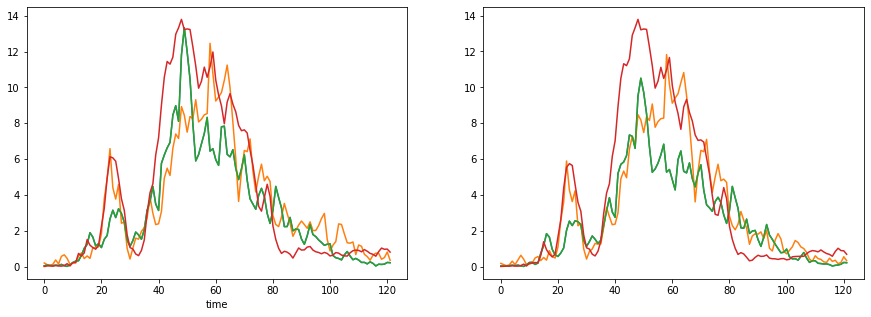

In [83]:
test_subj_idx = 1
test_cond_idx = 0
X_all_testc1 = X_all[6,test_cond_idx,test_subj_idx,:,:]
X_all_testc2 = X_all[3,test_cond_idx,test_subj_idx,:,:]
X_all_testc3 = X_all[6,test_cond_idx,test_subj_idx,:,:]
X_all_testc4 = X_all[2,test_cond_idx,test_subj_idx,:,:]

def meanstuff(X):
    return np.mean(X**2,axis=1)

def varstuff(X):
    return np.var(X,axis=1)

X_all_testplotc1 = meanstuff(X_all_testc1)
X_all_testplotc2 = meanstuff(X_all_testc2)
X_all_testplotc3 = meanstuff(X_all_testc3)
X_all_testplotc4 = meanstuff(X_all_testc4)

X_all_testvarc1 = varstuff(X_all_testc1)
X_all_testvarc2 = varstuff(X_all_testc2)
X_all_testvarc3 = varstuff(X_all_testc3)
X_all_testvarc4 = varstuff(X_all_testc4)

plot_times = np.array(range(n_time))

fig,(plt1,plt2) = plt.subplots(1,2)

plt1.plot(plot_times,X_all_testplotc1,plot_times,X_all_testplotc2, 
          plot_times,X_all_testplotc3, 
        plot_times,X_all_testplotc4)
fig.set_size_inches(15,5)

plt2.plot(plot_times,X_all_testvarc1,plot_times,X_all_testvarc2, 
          plot_times,X_all_testvarc3, 
        plot_times,X_all_testvarc4)
plt1.set_xlabel('time');

**Conclusion :** yes, traces on average aver very different across conditions... but they are also different comparing different trial types. 

**PROBLEM** if I want to classify conditions, it only makes sense to do it on a trial by trial basis.  Therefore I cannot use X_all but rather ERPs. 

**This file ends here.**